In [229]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,ExponentialSmoothing
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.api as smt

In [296]:
import warnings
warnings. filterwarnings('ignore')

In [297]:
df=pd.read_csv("exchange_rate.csv",index_col=['date'],parse_dates=True)

In [298]:
df

,Ex_rate
date,
1990-01-01,0.785500
1990-02-01,0.781800
1990-03-01,0.786700
1990-04-01,0.786000
1990-05-01,0.784900
...,...
2010-06-10,0.718494
2010-07-10,0.721839
2010-08-10,0.723197


In [256]:
df.shape

(7588, 1)

In [257]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB


In [258]:
df.columns

Index(['Ex_rate'], dtype='object')

In [259]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


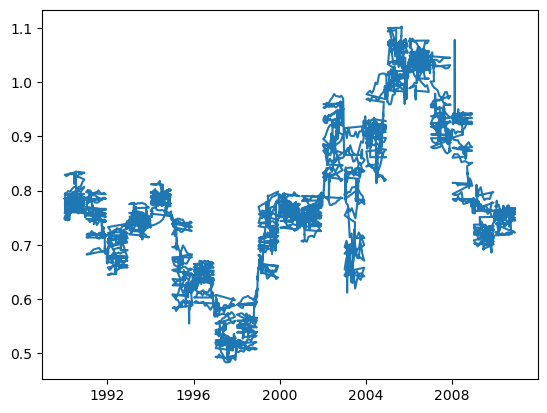

In [260]:
plt.plot(df)

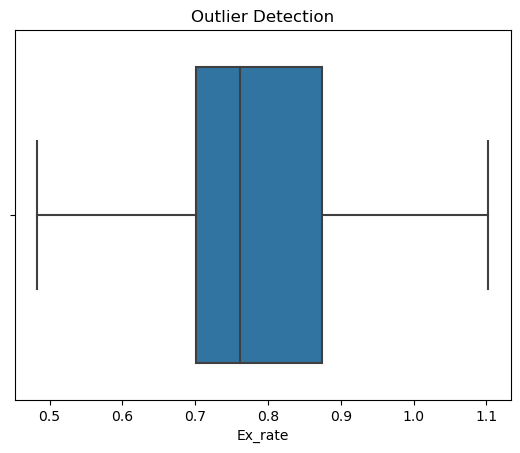

In [238]:
sns.boxplot(x=df['Ex_rate'])
plt.title('Outlier Detection')
plt.show()

In [239]:
df['Rolling_Mean']=df['Ex_rate'].rolling(window=12).mean()
Q1=df['Ex_rate'].quantile(0.25)
Q3=df['Ex_rate'].quantile(0.75)
IQR=Q3-Q1
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR
df.loc[df['Ex_rate']<lower_bound,'Ex_rate']=df['Rolling_Mean']
df.loc[df['Ex_rate']>upper_bound,'Ex_rate']=df['Rolling_Mean']

In [240]:
adf_test=adfuller(df['Ex_rate'].dropna())
print(f'ADF Statistic:{adf_test[0]}')

ADF Statistic:-1.664994180738078


In [241]:
print(f'p-value:{adf_test[1]}')

p-value:0.44923273535982894


In [184]:
df

,Ex_rate,Rolling_Mean
date,,
1990-01-01,0.785500,NaN
1990-02-01,0.781800,NaN
1990-03-01,0.786700,NaN
1990-04-01,0.786000,NaN
1990-05-01,0.784900,NaN
...,...,...
2010-06-10,0.718494,0.722488
2010-07-10,0.721839,0.721832
2010-08-10,0.723197,0.721288


#### ARIMA

In [185]:
def test_stationarity(timeseries):
    #Calculate rolling mean and rolling standard deviation
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()
    original = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'green', label = 'Rolling Std')
    plt.legend(loc='best')
    print('Results of Dickey-Fuller Test :\n')
    df_test = adfuller(timeseries)
    my_output = pd.Series(df_test[0:4], index =['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for i,j in df_test[4].items():
        my_output['Critical Value (%s)'%i] =j
    print(my_output)

In [186]:
df

,Ex_rate,Rolling_Mean
date,,
1990-01-01,0.785500,NaN
1990-02-01,0.781800,NaN
1990-03-01,0.786700,NaN
1990-04-01,0.786000,NaN
1990-05-01,0.784900,NaN
...,...,...
2010-06-10,0.718494,0.722488
2010-07-10,0.721839,0.721832
2010-08-10,0.723197,0.721288


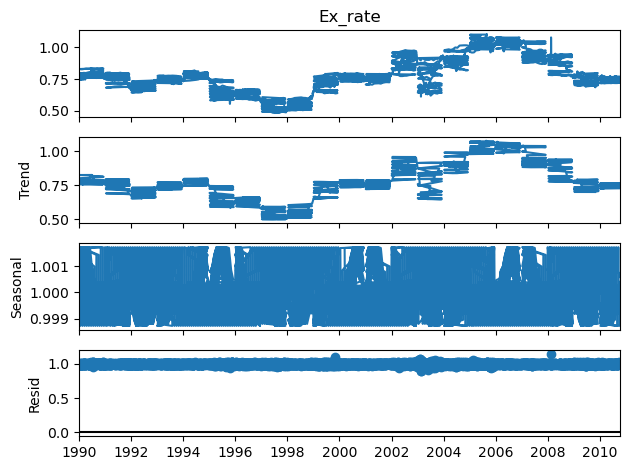

In [187]:
model=seasonal_decompose(df['Ex_rate'],model='multiplicative',period=30)
model.plot()
plt.show()

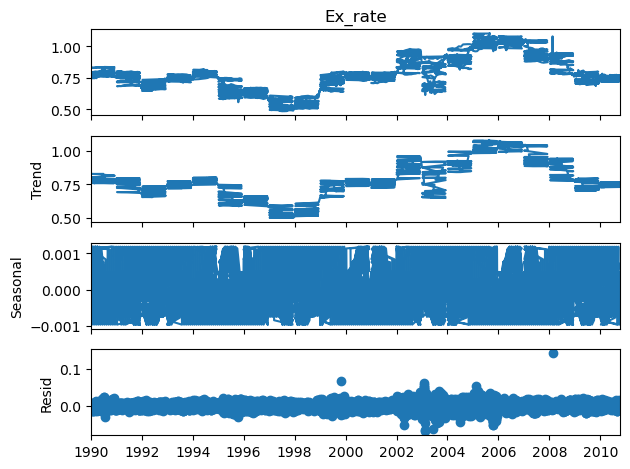

In [188]:
model=seasonal_decompose(df['Ex_rate'],model='additive',period=30)
model.plot()
plt.show()

Results of Dickey-Fuller Test :

Test Statistic                   -1.664994
p-value                           0.449233
#Lags Used                        1.000000
Number of Observations Used    7586.000000
Critical Value (1%)              -3.431212
Critical Value (5%)              -2.861921
Critical Value (10%)             -2.566973
dtype: float64


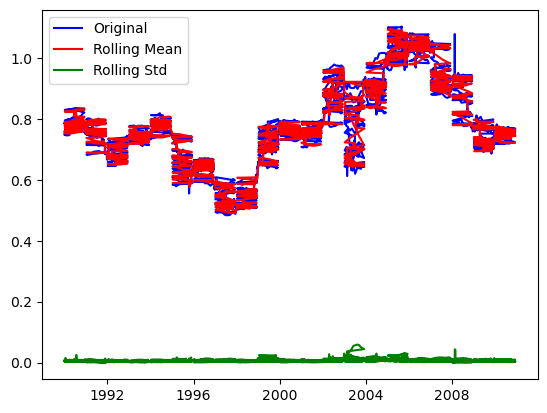

In [189]:
test_stationarity(df['Ex_rate'])

In [190]:
# Ho--- Data is not stationary
# Ha--- Data is stationary

In [191]:
# Here Test statistic>critical value that means we fail to reject Ho

##### Differencing

In [192]:
df['Ex_rate_diff']=df['Ex_rate']-df['Ex_rate'].shift(30)
df

,Ex_rate,Rolling_Mean,Ex_rate_diff
date,,,
1990-01-01,0.785500,NaN,NaN
1990-02-01,0.781800,NaN,NaN
1990-03-01,0.786700,NaN,NaN
1990-04-01,0.786000,NaN,NaN
1990-05-01,0.784900,NaN,NaN
...,...,...,...
2010-06-10,0.718494,0.722488,-0.029337
2010-07-10,0.721839,0.721832,-0.024597
2010-08-10,0.723197,0.721288,-0.015465


In [193]:
df.dropna(inplace=True)
df

,Ex_rate,Rolling_Mean,Ex_rate_diff
date,,,
1990-01-31,0.745700,0.760117,-0.039800
1990-01-02,0.750000,0.758783,-0.031800
1990-02-02,0.756700,0.757800,-0.030000
1990-03-02,0.759500,0.756908,-0.026500
1990-04-02,0.758600,0.755667,-0.026300
...,...,...,...
2010-06-10,0.718494,0.722488,-0.029337
2010-07-10,0.721839,0.721832,-0.024597
2010-08-10,0.723197,0.721288,-0.015465


Results of Dickey-Fuller Test :

Test Statistic                -9.289170e+00
p-value                        1.192623e-15
#Lags Used                     3.100000e+01
Number of Observations Used    7.526000e+03
Critical Value (1%)           -3.431219e+00
Critical Value (5%)           -2.861924e+00
Critical Value (10%)          -2.566974e+00
dtype: float64


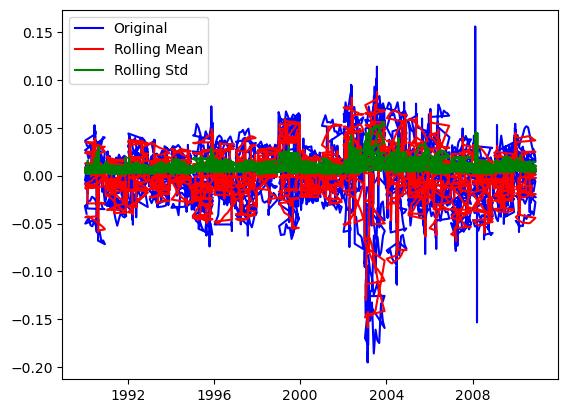

In [194]:
test_stationarity(df['Ex_rate_diff'])

In [195]:
# Here Test Statistic < Critical Value means we can reject H0
# Now our data is stationary

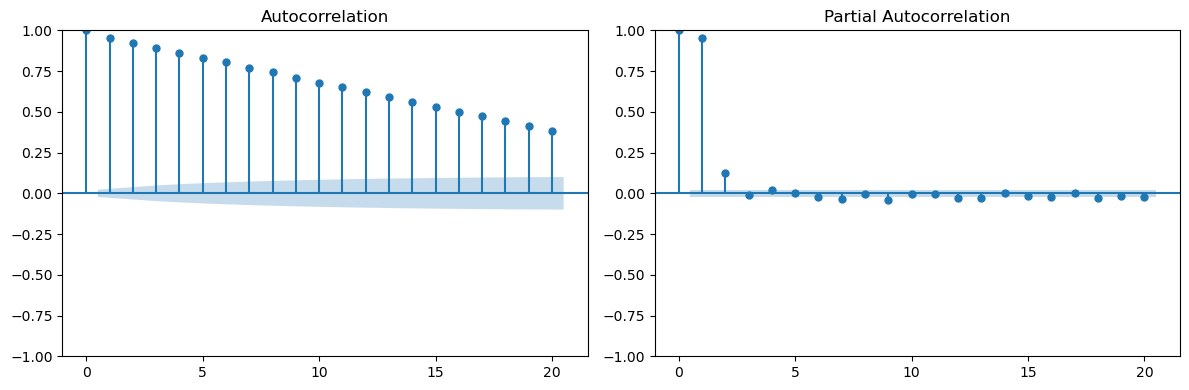

In [196]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(df['Ex_rate_diff'], lags=20, ax=axes[0])
smt.graphics.plot_pacf(df['Ex_rate_diff'], lags=20, ax=axes[1])
plt.tight_layout()

In [197]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df['Ex_rate'], order=(1,1,1))

In [198]:
result=model.fit()

In [199]:
predicted=result.predict()
predicted

date
1990-01-31    0.000000
1990-01-02    0.745700
1990-02-02    0.749429
1990-03-02    0.755803
1990-04-02    0.759118
                ...   
2010-06-10    0.718838
2010-07-10    0.718523
2010-08-10    0.721394
2010-09-10    0.723012
2010-10-10    0.721139
Name: predicted_mean, Length: 7558, dtype: float64

In [200]:
forecast=result.forecast(20)
forecast

7558    0.720828
7559    0.720828
7560    0.720828
7561    0.720828
7562    0.720828
7563    0.720828
7564    0.720828
7565    0.720828
7566    0.720828
7567    0.720828
7568    0.720828
7569    0.720828
7570    0.720828
7571    0.720828
7572    0.720828
7573    0.720828
7574    0.720828
7575    0.720828
7576    0.720828
7577    0.720828
Name: predicted_mean, dtype: float64

In [201]:
forecast=result.forecast(300)
forecast
last_date=df.index[-1] 
forecast_dates=pd.date_range(start=last_date,periods=300,freq='D') 
forecast.index=forecast_dates

print(forecast)

2010-10-10    0.720828
2010-10-11    0.720828
2010-10-12    0.720828
2010-10-13    0.720828
2010-10-14    0.720828
                ...   
2011-08-01    0.720828
2011-08-02    0.720828
2011-08-03    0.720828
2011-08-04    0.720828
2011-08-05    0.720828
Freq: D, Name: predicted_mean, Length: 300, dtype: float64


In [202]:
from pandas.tseries.offsets import DateOffset

<Axes: >

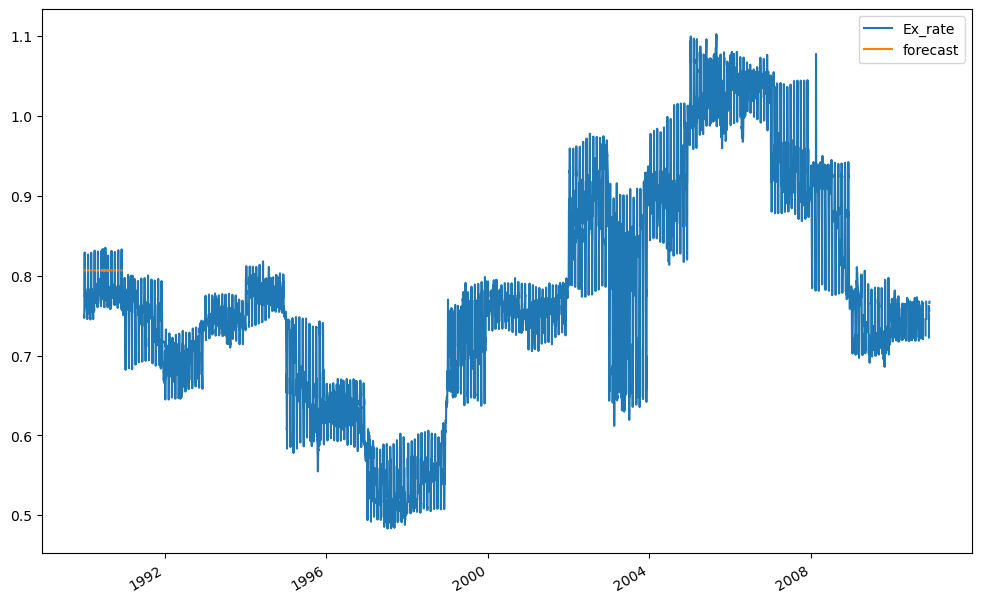

In [203]:
pred_date=[df.index[-1]+ DateOffset(days=x)for x in range(0,300)]
pred_date_rate=pd.DataFrame(index=pred_date[1:])
pred_date_rate
data=pd.concat([df,pred_date_rate])
data['forecast'] = result.predict(start = 130, end = 200,dynamic=True)
data[['Ex_rate','forecast']].plot(figsize=(12, 8))

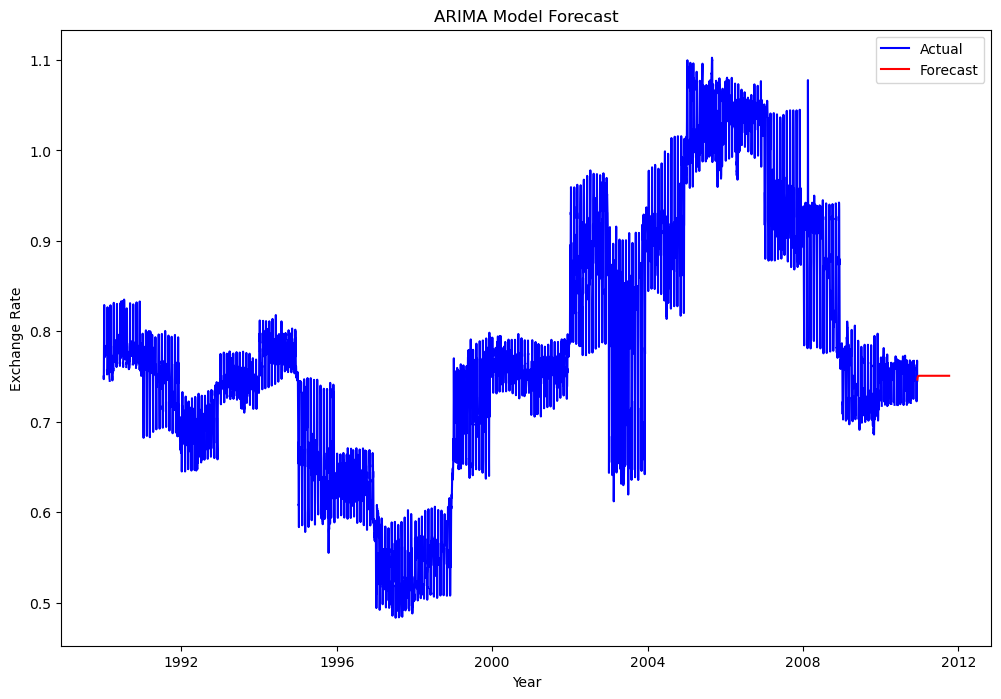

In [205]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Ensure the DataFrame index is datetime with frequency
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')

# Fit the ARIMA model
model = ARIMA(df['Ex_rate'], order=(1, 1, 1))  # Adjust (p, d, q) as needed
result = model.fit()

# Generate forecast for the next 300 days
forecast_steps = 300
last_date = df.index[-1]
future_dates = [last_date + DateOffset(days=x) for x in range(1, forecast_steps + 1)]
forecast = result.forecast(steps=forecast_steps)

# Create DataFrame for forecasted values
forecast_df = pd.DataFrame({'forecast': forecast}, index=future_dates)

# Combine original and forecasted data
combined_df = pd.concat([df, forecast_df])

# Plot the data
plt.figure(figsize=(12, 8))
plt.plot(combined_df.index, combined_df['Ex_rate'], label='Actual', color='blue')
plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecast', color='red')
plt.xlabel('Year')
plt.ylabel('Exchange Rate')
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()


#### Model Building - Exponential Smoothing

In [261]:
import warnings
warnings.filterwarnings('ignore')
simple=SimpleExpSmoothing(df['Ex_rate']).fit(smoothing_level=.5)

In [262]:
simple.fittedvalues

date
1990-01-01    0.785500
1990-02-01    0.785500
1990-03-01    0.783650
1990-04-01    0.785175
1990-05-01    0.785587
                ...   
2010-06-10    0.719158
2010-07-10    0.718826
2010-08-10    0.720332
2010-09-10    0.721765
2010-10-10    0.721295
Length: 7588, dtype: float64

In [263]:
sim_forecast=simple.forecast(300)
last_date=df.index[-1] 
forecast_dates_sim=pd.date_range(start=last_date,periods=300,freq='D') 
forecast.index=forecast_dates_sim
print(sim_forecast)

7588    0.72106
7589    0.72106
7590    0.72106
7591    0.72106
7592    0.72106
         ...   
7883    0.72106
7884    0.72106
7885    0.72106
7886    0.72106
7887    0.72106
Length: 300, dtype: float64


In [264]:
df['SES']=SimpleExpSmoothing(df['Ex_rate']).fit(smoothing_level=.5).fittedvalues

In [265]:
df

,Ex_rate,SES
date,,
1990-01-01,0.785500,0.785500
1990-02-01,0.781800,0.785500
1990-03-01,0.786700,0.783650
1990-04-01,0.786000,0.785175
1990-05-01,0.784900,0.785587
...,...,...
2010-06-10,0.718494,0.719158
2010-07-10,0.721839,0.718826
2010-08-10,0.723197,0.720332


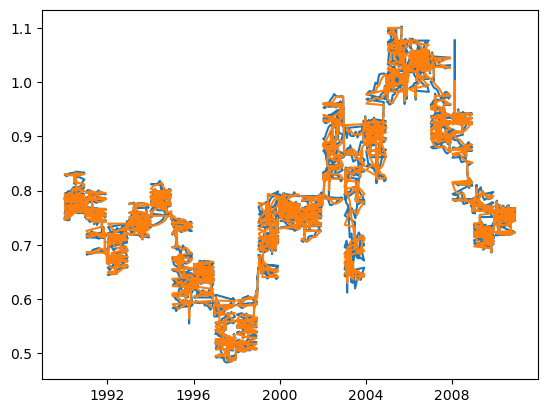

In [266]:
plt.plot(df)

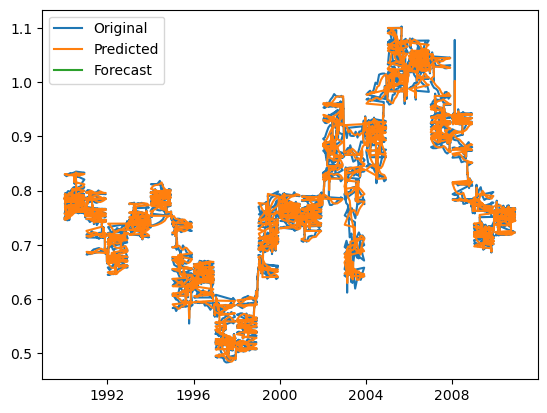

In [281]:
plt.plot(df['Ex_rate'],label='Original')
plt.plot(df['SES'],label="Predicted")
plt.plot(sim_forecast,label='Forecast')
plt.legend()

#### double_expo_smoothening

In [299]:
double=ExponentialSmoothing(df['Ex_rate'],trend='multiplicative').fit(smoothing_level=0.5,smoothing_trend=0.6)

In [300]:
double.fittedvalues

date
1990-01-01    0.783912
1990-02-01    0.785175
1990-03-01    0.782944
1990-04-01    0.785407
1990-05-01    0.786467
                ...   
2010-06-10    0.718717
2010-07-10    0.718643
2010-08-10    0.721240
2010-09-10    0.723809
2010-10-10    0.723012
Length: 7588, dtype: float64

In [301]:
dub_forecast=double.forecast(300)
dub_forecast
last_date=df.index[-1] 
forecast_dates=pd.date_range(start=last_date,periods=300,freq='D') 
forecast.index=forecast_dates
forecast_dates
print(dub_forecast)

7588    0.721958
7589    0.721997
7590    0.722036
7591    0.722075
7592    0.722114
          ...   
7883    0.733582
7884    0.733622
7885    0.733662
7886    0.733701
7887    0.733741
Length: 300, dtype: float64


In [302]:
df['DES']=ExponentialSmoothing(df['Ex_rate'],trend='multiplicative').fit(smoothing_level=0.5,smoothing_trend=0.6).fittedvalues

In [303]:
df

,Ex_rate,DES
date,,
1990-01-01,0.785500,0.783912
1990-02-01,0.781800,0.785175
1990-03-01,0.786700,0.782944
1990-04-01,0.786000,0.785407
1990-05-01,0.784900,0.786467
...,...,...
2010-06-10,0.718494,0.718717
2010-07-10,0.721839,0.718643
2010-08-10,0.723197,0.721240


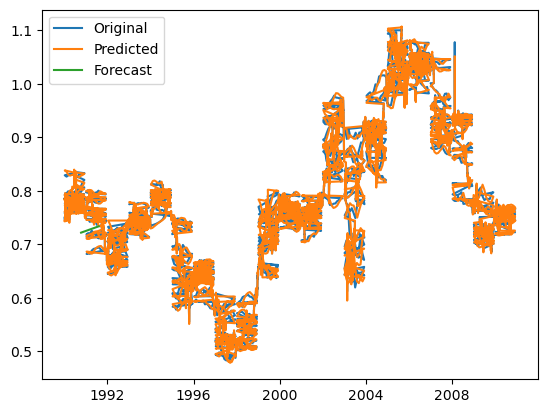

In [304]:
plt.plot(df['Ex_rate'],label='Original')
plt.plot(df['DES'],label="Predicted")
plt.plot(dub_forecast,label='Forecast')
plt.legend()

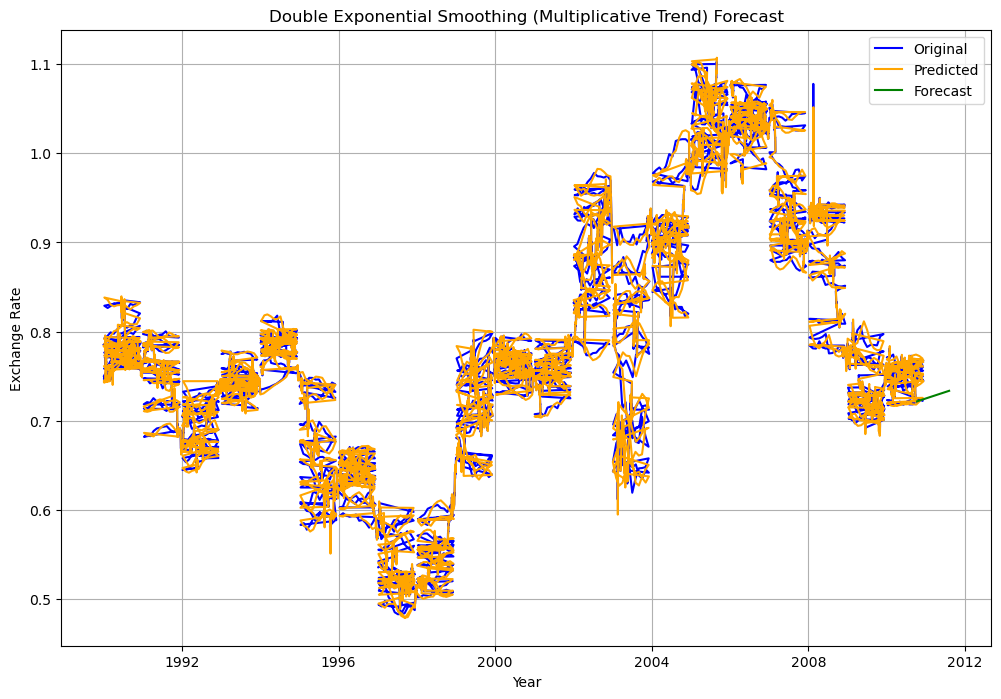

In [306]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import pandas as pd

# Fit the Double Exponential Smoothing model
double_model = ExponentialSmoothing(df['Ex_rate'], trend='multiplicative').fit(smoothing_level=0.5, smoothing_trend=0.6)

# Generate forecast for the next 300 days
forecast_steps = 300
last_date = df.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Forecasted values
dub_forecast = double_model.forecast(steps=forecast_steps)

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Forecast': dub_forecast.values}, index=forecast_dates)

# Add fitted values to the original DataFrame for plotting
df['DES'] = double_model.fittedvalues

# Plot the data
plt.figure(figsize=(12, 8))

# Plot original values
plt.plot(df.index, df['Ex_rate'], label='Original', color='blue')

# Plot predicted (fitted) values
plt.plot(df.index, df['DES'], label='Predicted', color='orange')

# Plot forecasted values
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='green')

# Add labels, legend, and grid
plt.xlabel('Year')
plt.ylabel('Exchange Rate')
plt.title('Double Exponential Smoothing (Multiplicative Trend) Forecast')
plt.legend()
plt.grid()
plt.show()


#### triple_exp_smoothing

In [307]:
triple=ExponentialSmoothing(df['Ex_rate'],trend='additive',seasonal='additive',seasonal_periods=2).fit(smoothing_level=0.5,smoothing_trend=0.6,smoothing_seasonal=0.7)

In [308]:
triple.fittedvalues

date
1990-01-01    0.785952
1990-02-01    0.780822
1990-03-01    0.787492
1990-04-01    0.783249
1990-05-01    0.790154
                ...   
2010-06-10    0.718476
2010-07-10    0.717592
2010-08-10    0.720840
2010-09-10    0.726067
2010-10-10    0.722382
Length: 7588, dtype: float64

In [309]:
trp_forecast=triple.forecast(300)
trp_forecast
last_date=df.index[-1] 
forecast_dates=pd.date_range(start=last_date,periods=300,freq='D') 
forecast.index=forecast_dates
forecast_dates
print(trp_forecast)


7588    0.718293
7589    0.720431
7590    0.717121
7591    0.719259
7592    0.715949
          ...   
7883    0.548126
7884    0.544815
7885    0.546954
7886    0.543643
7887    0.545782
Length: 300, dtype: float64


In [310]:
df['TES']=ExponentialSmoothing(df['Ex_rate'],trend='multiplicative',seasonal='multiplicative',seasonal_periods=2).fit(smoothing_level=0.5,smoothing_trend=0.6,smoothing_seasonal=0.7).fittedvalues

In [311]:
df

,Ex_rate,DES,TES
date,,,
1990-01-01,0.785500,0.783912,0.785947
1990-02-01,0.781800,0.785175,0.780792
1990-03-01,0.786700,0.782944,0.787483
1990-04-01,0.786000,0.785407,0.783240
1990-05-01,0.784900,0.786467,0.790168
...,...,...,...
2010-06-10,0.718494,0.718717,0.718476
2010-07-10,0.721839,0.718643,0.717597
2010-08-10,0.723197,0.721240,0.720846


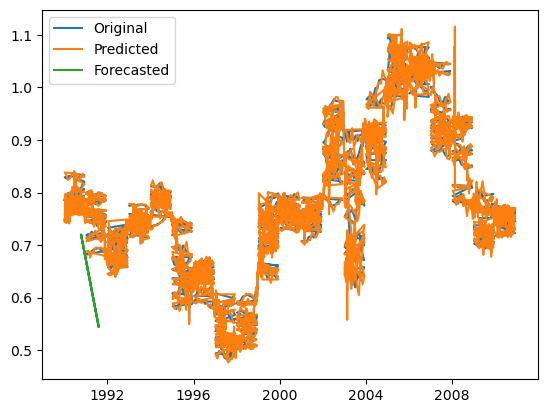

In [312]:
plt.plot(df['Ex_rate'],label='Original')
plt.plot(df['TES'],label="Predicted")
plt.plot(trp_forecast,label='Forecasted')
plt.legend()

#Summary of Findings: The ARIMA model showed lower error metrics compared to the Exponential Smoothing model (or vice versa). Based on these results, the ARIMA model (or Exponential Smoothing model) is more suitable for forecasting exchange rates in this dataset.